DESCRIPTION

Data Analysis is the process of creating a story using the data for easy and effective communication. It mostly utilizes visualization methods like plots, charts, and tables to convey what the data holds beyond the formal modeling or hypothesis testing task.

Domain: Finance

Read the information given below and also refer to the data dictionary provided separately in an excel file to build your understanding.

Problem Statement

Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates.
The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default.

There is 1 dataset data that have 41 attributes.
You are required to determine and examine factors that affected the ratio of vehicle loan defaulters. Also, use the findings to create a model to predict the potential defaulters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('loan_data.csv')

In [3]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
categorical_columns = ['credit.policy','purpose','inq.last.6mths','delinq.2yrs','pub.rec','not.fully.paid']

##### Check if any feature is strongly correlated with each other. Also check if any feature is strongly correlated with the target
##### Since the values for each of the columns are at different scales we first scale down using a standard scaler.

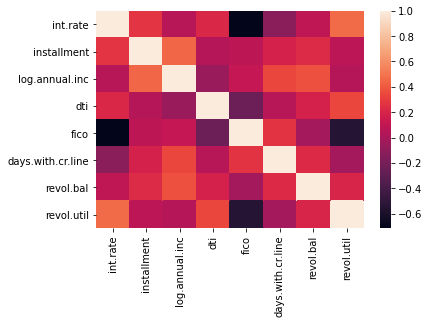

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util
int.rate,1,0.27614,0.0563825,0.220006,-0.714821,-0.124022,0.0925271,0.464837
installment,0.27614,1,0.448102,0.0502018,0.0860394,0.183297,0.233625,0.0813562
log.annual.inc,0.0563825,0.448102,1,-0.0540648,0.114576,0.336896,0.37214,0.0548811
dti,0.220006,0.0502018,-0.0540648,1,-0.241191,0.0601011,0.188748,0.337109
fico,-0.714821,0.0860394,0.114576,-0.241191,1,0.26388,-0.0155525,-0.541289
days.with.cr.line,-0.124022,0.183297,0.336896,0.0601011,0.26388,1,0.229344,-0.0242393
revol.bal,0.0925271,0.233625,0.37214,0.188748,-0.0155525,0.229344,1,0.203779
revol.util,0.464837,0.0813562,0.0548811,0.337109,-0.541289,-0.0242393,0.203779,1


In [7]:
def func(x):
    try:
        return (x - x.std())/x.mean()
    except:
        pass
sns.heatmap(df[[col for col in df.columns if col not in categorical_columns]].apply(func).corr())
plt.show()
df[[col for col in df.columns if col not in categorical_columns]].apply(func).corr().style.applymap(lambda x: "background-color:red" if abs(x)>0.5 else "")

##### revol.util and fico, fico and int.rate has high correlation. Drop int.rate column

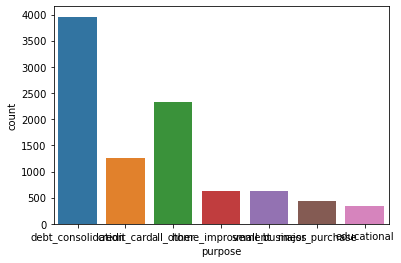

In [8]:
sns.countplot(df.purpose)
plt.show()

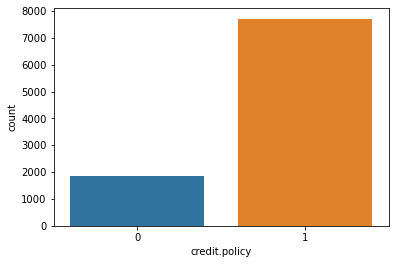

In [9]:
sns.countplot(df['credit.policy'])
plt.show()

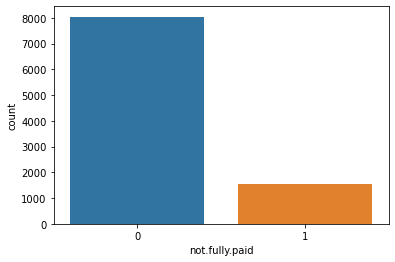

In [10]:
sns.countplot(df['not.fully.paid'])
plt.show()

##### Column "purpose" is a categorical column and we have to one hot encode it before passing to model. The countplot shows most of the data we have has the purpose of debt consolidation and the feature is imbalanced. We use the pandas

In [11]:
df = pd.get_dummies(df)

##### There is a lot of overlap between the target class. Using SMOTE to perform oversampling would render ineffective due to this

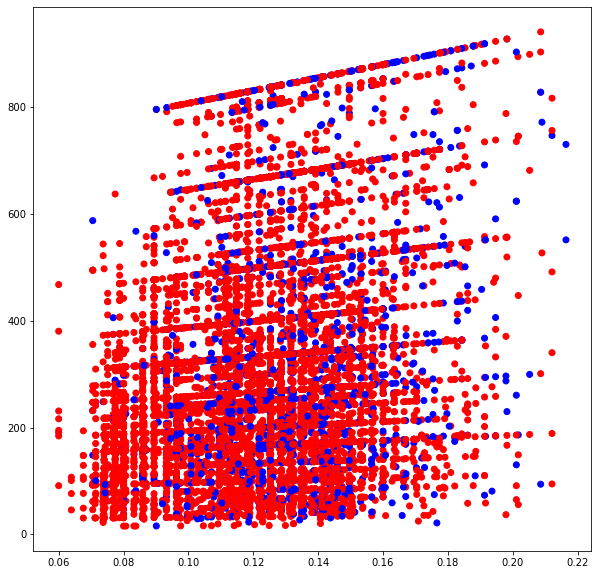

In [12]:
dic = {0:'red',1:'blue'}
plt.figure(figsize=(10,10))
plt.scatter(df['int.rate'],df['installment'],c=df['not.fully.paid'].apply(dic.get))
plt.show()

##### All the continuous variables seem close to a normal distribution except revol.util and revol.bal. We can use standard scaler to feature scale the normal like distributions and a min max scaler for uniformly distributed features.
##### Revol.bal is a highly left skewed feature. This might a log tranformation or square root or cube root ransformation.

In [13]:
categorical_columns += [col for col in df.columns if 'purpose' in col]

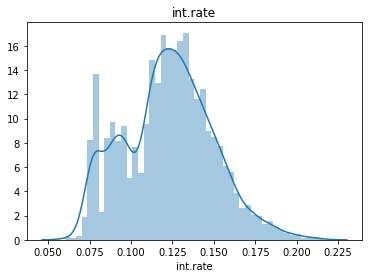

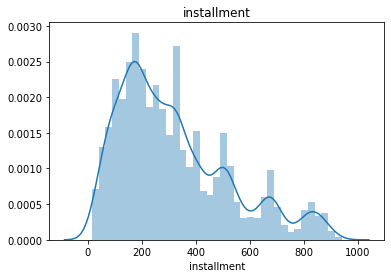

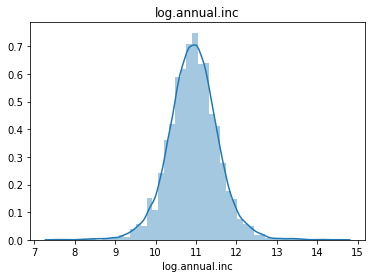

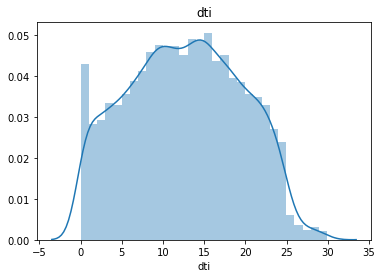

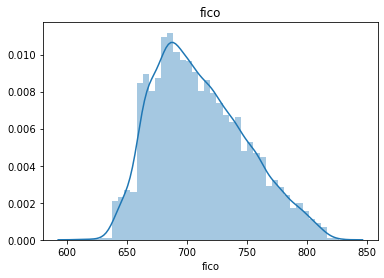

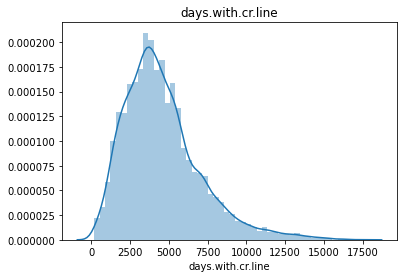

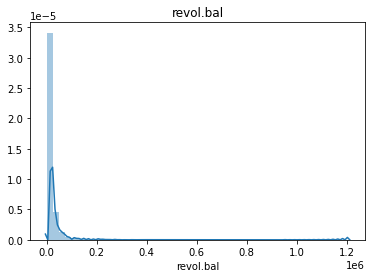

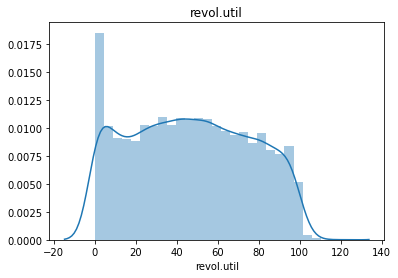

In [14]:
for col in df.columns:
    if col in categorical_columns:
        continue
    plt.title(f'{col}')
    sns.distplot(df[col],)
    plt.show()

##### No columns have null values.

In [15]:
df.isna().sum()

credit.policy                 0
int.rate                      0
installment                   0
log.annual.inc                0
dti                           0
fico                          0
days.with.cr.line             0
revol.bal                     0
revol.util                    0
inq.last.6mths                0
delinq.2yrs                   0
pub.rec                       0
not.fully.paid                0
purpose_all_other             0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_major_purchase        0
purpose_small_business        0
dtype: int64

#### log.annual.inc, days.with.cr.line, revol.bal have lots of outliers. 
##### log.annual.inc is a normal distribution. When we scale it using a standard scaler the effect of outliers will be reduced. No transformation is required for this feature
##### days.with.cr.line has a slight left skew. We can either apply a log transformation or directly use a standard scaler to reduce the outliers due to the smoothness of data distribution for this feature
##### revol.bal is highly left skewed and has a huge amount of outliers. A log transformation is required and then it can be scaled.

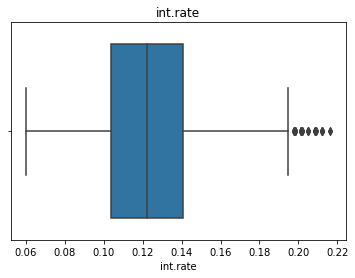

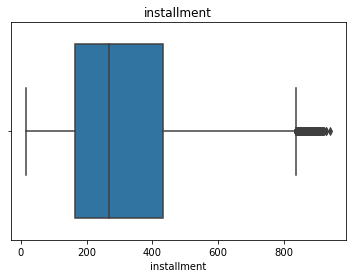

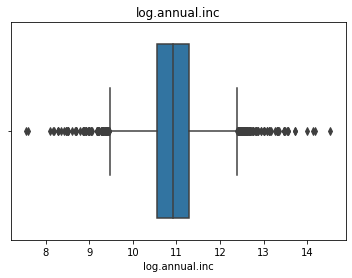

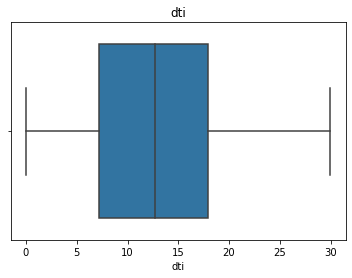

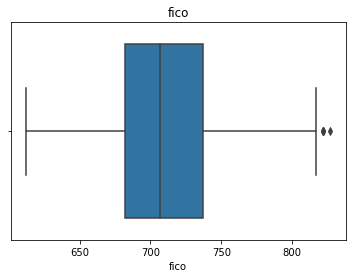

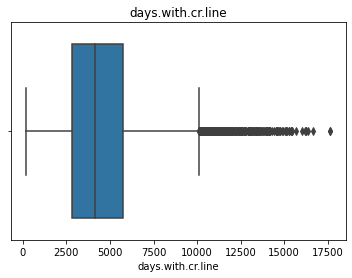

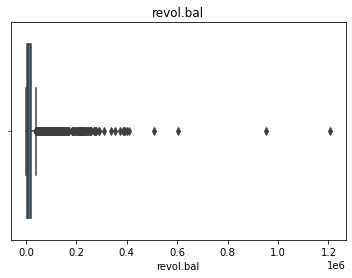

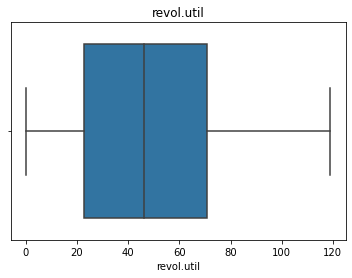

In [16]:
for col in df.columns:
    if col in categorical_columns:
        continue
    plt.title(f'{col}')
    sns.boxplot(df[col],)
    plt.show()

##### fifth root transformation for revol.bal. 

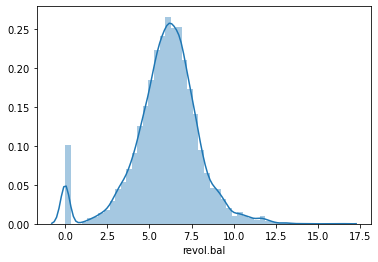

In [17]:
df['revol.bal'] = np.power(df['revol.bal'],1/5)
sns.distplot(df[df['revol.bal'] != float('-inf')]['revol.bal'])
plt.show()

In [18]:
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,7.799041,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,8.041319,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,5.117834,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,8.043423,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,5.434451,39.5,0,1,0,0,0,1,0,0,0,0,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='not.fully.paid'),df['not.fully.paid'])

##### Feature Scaling continuous variables

In [20]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

X_train[[col for col in X_train.columns if col not in categorical_columns + ['revol.util']]] = \
                                std_scaler.fit_transform(X_train[[col for col in X_train.columns if col not in categorical_columns+ ['revol.util']]])

X_train[['revol.util']] = min_max_scaler.fit_transform(X_train[['revol.util']])

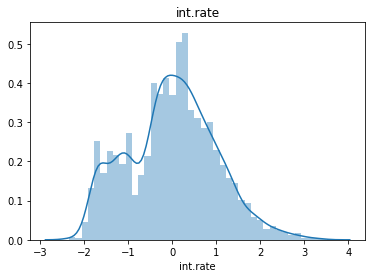

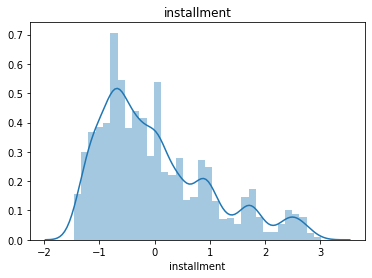

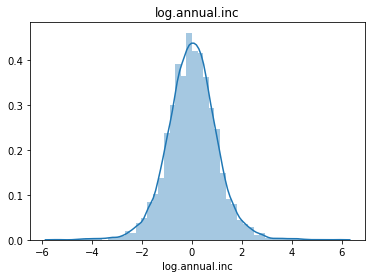

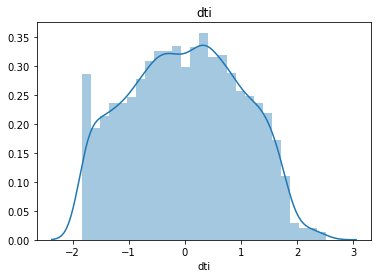

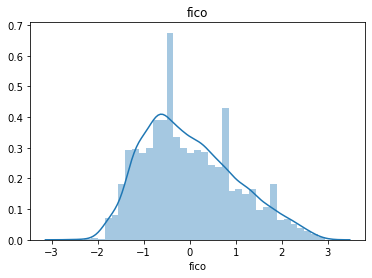

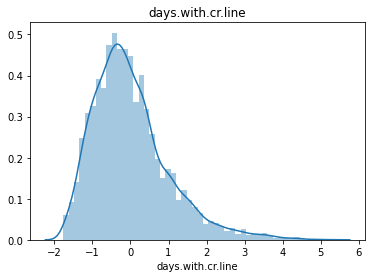

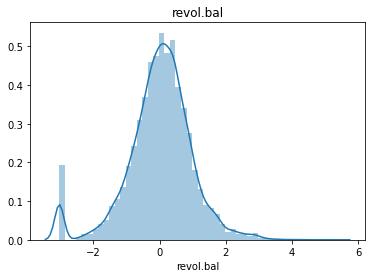

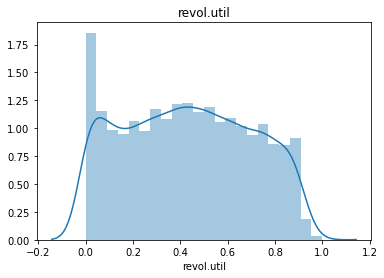

In [21]:
for col in df.columns:
    if col in categorical_columns:
        continue
    plt.title(f'{col}')
    sns.distplot(X_train[col],)
    plt.show()

In [ ]:
over = SVMSMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.7)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
X_, y_ = pipeline.fit_resample(X_train,y_train)
sns.countplot(y_)

##### Performing feature engineering - Using PCA with 7 components. The 7 components can explain 90% of the variance and 8 components explain 92% which is not a huge difference. Hence we limit to 7 components

In [ ]:
for i in range(5,20):
    pca = PCA(n_components=i)
    pca.fit(X_)
    print(i)
    print(pca.explained_variance_ratio_.sum())
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.show()

In [ ]:
pca = PCA(n_components=10)
pca_X_train = pca.fit_transform(X_)

In [22]:
model = Sequential()
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [23]:
X_test[[col for col in X_train.columns if col not in categorical_columns + ['revol.util']]] = \
std_scaler.transform(X_test[[col for col in X_train.columns if col not in categorical_columns + ['revol.util']]])
X_test[['revol.util']] = min_max_scaler.fit_transform(X_test[['revol.util']])

In [24]:
model.compile(loss='binary_crossentropy',optimizer = 'sgd', metrics='accuracy')

In [26]:
model.fit(X_train,y_train,epochs=300,batch_size=128)
# ,validation_data=(X_test,y_test))

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

57/57 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6495
Epoch 2/300
57/57 [==============================] - 0s 3ms/step - loss: 0.5594 - accuracy: 0.8151
Epoch 3/300
57/57 [==============================] - 0s 3ms/step - loss: 0.5248 - accuracy: 0.8349
Epoch 4/300
57/57 [==============================] - 0s 3ms/step - loss: 0.5090 - accuracy: 0.8395
Epoch 5/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4981 - accuracy: 0.8398
Epoch 6/300
5

57/57 [==============================] - 0s 3ms/step - loss: 0.4372 - accuracy: 0.8410
Epoch 157/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4374 - accuracy: 0.8410
Epoch 158/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4369 - accuracy: 0.8410
Epoch 159/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4374 - accuracy: 0.8410
Epoch 160/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.8410
Epoch 161/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4368 - accuracy: 0.8410
Epoch 162/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4367 - accuracy: 0.8410
Epoch 163/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8410
Epoch 164/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4359 - accuracy: 0.8410
Epoch 165/300
57/57 [==============================] - 0s 3ms/step - loss: 0.4359 - accuracy: 0.8410
Epoc

##### VALIDATION ACCURACY is 84%

In [27]:
model.evaluate(X_test,y_test)

75/75 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.8367


[0.43742635846138, 0.8367432355880737]